<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Checking out files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:20<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:05<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:09<00:00, 70.9MB/s]


In [41]:
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install facenet-pytorch --quiet
!pip install timm --quiet
import timm
from facenet_pytorch import MTCNN
from PIL import Image
import shutil
# ignore np.VisibleDeprecationWarning for image_index because it contains list of lists of different lengths
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)
    

In [5]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': False})

In [6]:
batch_size = 32
train_loader = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

# PART 1 : Face Analysis

## Subpart 1

### Step 1

In [ ]:
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Lambda(lambda x: x.permute(2, 0, 1)),
#     torchvision.transforms.Resize((160, 160)),
#     torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
#     ])

In [7]:
# define a function like crop_faces that takes as input an image, and the boxes
# and returns a list with length of batch size, where each element is a list of the cropped faces for that image and none if no faces are detected
def crop_faces_batch(image, boxes):
    """
    :param image: image tensor of shape (batch_size, height, width, channels)
    :param boxes: bounding boxes for the faces of shape (batch_size, num_faces, 4) where 4 is (x1, y1, x2, y2). Note that some images may not have any faces
    :return: 
    :param cropped_images: list of cropped faces with length equal to the batch size. each element is a list of cropped faces for that image and none if no faces are detected
    """
    cropped_images = []
    for i in range(image.shape[0]):
        current_image = image[i]
        if boxes[i] is not None:
            current_cropped_images = []
            for j in range(boxes[i].shape[0]):
                current_box = boxes[i][j]
                x1, y1, x2, y2 = current_box
                x1, y1, x2, y2 = max(int(x1), 0), max(int(y1), 0), max(int(x2), 0), max(int(y2), 0)
                cropped_image = current_image[y1:y2, x1:x2]
                current_cropped_images.append(cropped_image)
            cropped_images.append(current_cropped_images)
        else:
            cropped_images.append(None)
    return cropped_images

In [ ]:
# define a function that given the data loader, uses the crop_faces_batch to save the cropped images and their sentiments
def save_cropped_images(data_loader, face_detector, faces_path, sentiments_path):
    """
    :param data_loader: data loader for the dataset
    :param face_detector: face detector
    :param faces_path: path to save the cropped faces
    :param sentiments_path: path to save the sentiments
    :return: 
    """
    sentiments = []
    image_index = 0
    if not os.path.exists(faces_path):
        os.makedirs(faces_path)
    else:
        shutil.rmtree(faces_path)
        os.makedirs(faces_path)
    for i, (image, sentiment) in enumerate(data_loader):
        if i % 50 == 0:
              print("Processing batch {}/{}".format(i+1, len(data_loader)))
        boxes, _ = face_detector.detect(image)
        cropped_images_batch = crop_faces_batch(image, boxes)
        # cropped_images_batch contains a list, where each element is a list with length equal to the number of faces in that image and none if no faces are detected
        # we want to save the cropped images with their corresponding sentiments
        for j in range(len(cropped_images_batch)):
            if cropped_images_batch[j] is not None:
                sentiments.extend([sentiment[j]] * len(cropped_images_batch[j]))
                for k in range(len(cropped_images_batch[j])):
                    image_path = os.path.join(faces_path, str(image_index)+'.jpg')
                    image = cropped_images_batch[j][k].numpy()
                    image = Image.fromarray(image)
                    image.save(image_path)
                    image_index += 1
    with open(sentiments_path, 'w') as f:
        for sentiment in sentiments:
            f.write(str(sentiment.item()) + '\n')
        
    
face_detector = MTCNN(keep_all=True, device=device)
# save the cropped faces and sentiments for the train, dev, and test sets
save_cropped_images(train_loader, face_detector, 'data/train/image', 'data/train/train_sentiments.txt')
save_cropped_images(dev_loader, face_detector, 'data/dev/image', 'data/dev/dev_sentiments.txt')
save_cropped_images(test_loader, face_detector, 'data/test/image', 'data/test/test_sentiments.txt')


Processing batch 1/633
Processing batch 51/633
Processing batch 101/633
Processing batch 151/633
Processing batch 201/633
Processing batch 251/633
Processing batch 301/633
Processing batch 351/633
Processing batch 401/633
Processing batch 451/633
Processing batch 501/633
Processing batch 551/633
Processing batch 601/633
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159


In [ ]:
# zip the folders data/train, data/dev, and data/test
shutil.make_archive('data/train', 'zip', 'data/train')
shutil.make_archive('data/dev', 'zip', 'data/dev')
shutil.make_archive('data/test', 'zip', 'data/test')

'/content/data/test.zip'

In [ ]:
# Download zip files from drive
# TODO
# !gdown 1QSLi3ItJMrcwISupP1qtBSFKb7sYgOue # train
# !gdown 1-2uLyYmclWDh1d9CA3FSNf4c6OZOIkvi # Dev
# !gdown 1-5ZJv6g5sdGXiB2EkEZkFU367EXlELeV # Test

### Step 2

In [58]:
# create a custom dataset class that takes as input the cropped faces path and the sentiments path 
# the sentiments are the targets for the model
class CroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        # TODO: implement this function
        self.faces_path = faces_path
        self.transform = transform
        self.sentiments = np.loadtxt(sentiments_path)
        self.sentiments = torch.from_numpy(self.sentiments)
        self.sentiments = self.sentiments.type(torch.LongTensor)
    
    def __getitem__(self, index):
        # TODO: implement this function
        image_path = os.path.join(self.faces_path, str(index)+'.jpg')
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        sentiment = self.sentiments[index]
        return image, sentiment
    def __len__(self):
        # TODO: implement this function
        return len(self.sentiments)

In [59]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CroppedFaces('data/train/image', 'data/train/train_sentiments.txt', transform=image_transform)
dev_dataset = CroppedFaces('data/dev/image', 'data/dev/dev_sentiments.txt', transform=image_transform)
test_dataset = CroppedFaces('data/test/image', 'data/test/test_sentiments.txt', transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

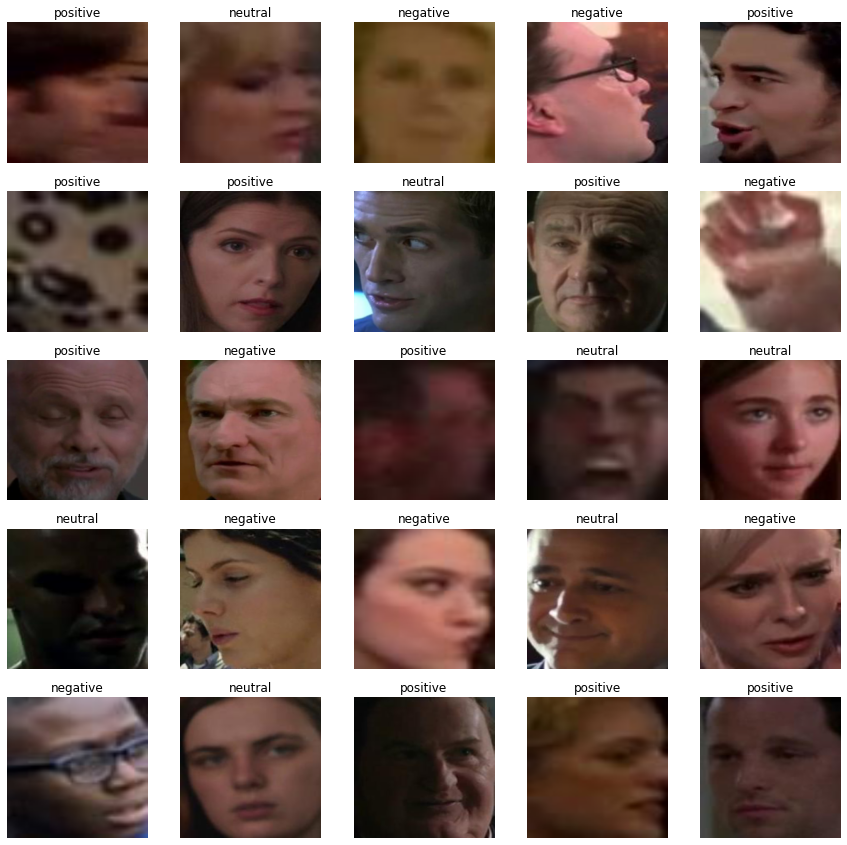

In [36]:
# show some images from the train set
def plot_random_images(dataset, num_cols, num_rows):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    for i in range(num_rows):
        for j in range(num_cols):
            index = np.random.randint(len(dataset))
            image, sentiment = dataset[index]
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            image = (image + 1) / 2
            axes[i, j].imshow(image)
            # set title to positive if sentiment is 2, negative if 1, and neutral if 0
            axes[i, j].set_title('positive' if sentiment == 2 else 'negative' if sentiment == 1 else 'neutral')
            axes[i, j].axis('off')
    plt.show()

plot_random_images(train_dataset, 5, 5)

In [ ]:
# define the model
class FaceSentimentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: implement this function
        raise NotImplementedError
    def forward(self, x):
        # TODO: implement this function
        raise NotImplementedError

In [63]:
# Instantiate the model, move it to device, and define the optimizer and loss function
model = timm.create_model('resnet18', pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [64]:
# define a function to train the model
def train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10):
    """
    :param model: model to train
    :param train_loader: train data loader
    :param dev_loader: dev data loader
    :param optimizer: optimizer to use
    :param loss_function: loss function to use
    :param num_epochs: number of epochs to train for
    :return: train_losses, train_accs, dev_losses, dev_accs
    """
    train_losses = []
    train_accs = []
    dev_losses = []
    dev_accs = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        model.train()
        train_loss = 0
        train_correct = 0
        for i, (image, sentiment) in enumerate(train_loader):
            image = image.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, sentiment)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print("Train loss: {}, train accuracy: {}".format(train_loss, train_acc))
        model.eval()
        dev_loss = 0
        dev_correct = 0
        with torch.no_grad():
            for i, (image, sentiment) in enumerate(dev_loader):
                image = image.to(device)
                sentiment = sentiment.to(device)
                output = model(image)
                loss = loss_function(output, sentiment)
                dev_loss += loss.item()
                dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        dev_loss /= len(dev_loader)
        dev_acc = dev_correct / len(dev_dataset)
        dev_losses.append(dev_loss)
        dev_accs.append(dev_acc)
        print("Dev loss: {}, dev accuracy: {}".format(dev_loss, dev_acc))
    return train_losses, train_accs, dev_losses, dev_accs


In [ ]:
# train the model
train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10)

Epoch 1/10
Train loss: 1.099117688440906, train accuracy: 0.3696842105263158
Dev loss: 1.0936703712909253, dev accuracy: 0.36552567237163813
Epoch 2/10
Train loss: 1.0940972452954307, train accuracy: 0.37243724696356273
Dev loss: 1.1065989020582918, dev accuracy: 0.3653898397174681
Epoch 3/10


In [ ]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    raise NotImplementedError

# plot the train and dev losses and accuracies
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

### Step 3

In [ ]:
# define a function that takes as input the FaceSentimentClassifier model, the crop_faces_batch function, the data loader, and the device, the face_detector
# the function should iterate over the data loader and for each image, detect the faces in the image using the face_detector
# Then pass the image and boxes to the crop_faces_batch function to get the cropped faces
# Then iterate over the cropped faces list
# For each image, the corresponding element in the cropped_faces list is a list of cropped faces
# If the element is not None, then iterate over the list and pass each cropped face to the model to get the sentiment prediction
# Then combine the predictions of the cropped faces in the image to get the sentiment prediction for the image
# Finally, return the predictions and the targets
def get_predictions(model, crop_faces_batch, data_loader, device, face_detector):
    # TODO: implement this function
    raise NotImplementedError

## Subpart 2

### Step 1: Use [this paper](https://arxiv.org/abs/2112.13547) to create new images with data augmentation

In [ ]:
# create new images with data augmentation with the method mentioned in https://arxiv.org/abs/2112.13547
# the new images should be saved in the data/train_augmented folder
# the new images should be saved with the same name as the original image with the suffix _augmented_1, _augmented_2, etc.

# define the data augmentation pipeline
class PRIME:
    def __init__(self):
        # TODO: implement this function
        pass
    
    def operation1(self, image:Image) -> Image:
        raise NotImplementedError
    
    def operation2(self, image:Image) -> Image:
        raise NotImplementedError
    
    def augment(self, image:Image) -> Image:
        # TODO: implement this function
        raise NotImplementedError

# create the PRIME object
prime = PRIME()

In [ ]:
# define a function that takes as input the image path, and the PRIME object and the augmented images path and number of augmented images to create
# the function should read the image, apply the PRIME augmentation pipeline to the image, and save the augmented images in the augmented images path
def augment_image(image_path, data_augmenter, augmented_images_path, num_augmented_images=10):
    # TODO: implement this function

### Step 2

In [ ]:
# Evaluate FaceSentimentClassifier model with the augmented data
# create the augmented dataset class
class AugmentedCroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        # TODO: implement this function
        raise NotImplementedError

    def __getitem__(self, index):
        # TODO: implement this function
        raise NotImplementedError
        
    def __len__(self):
        # TODO: implement this function
        raise NotImplementedError

In [ ]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
image_transform = None # TODO

train_dataset = None # TODO
dev_dataset = None # TODO
test_dataset = None # TODO

train_loader = None # TODO
dev_loader = None # TODO
test_loader = None # TODO

In [ ]:
# use model trained on the original data to evaluate on the augmented data
# define a funcion that takes as input the model, the data loader, and the device and gives the accuracy of the model on the data loader
def get_accuracy(model, data_loader, device):
    # TODO: implement this function
    raise NotImplementedError

### Step 3

In [ ]:
# Create a new dataset that combines the original data and the augmented data
# define the combined dataset class
class CombinedCroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        # TODO: implement this function
        raise NotImplementedError

    def __getitem__(self, index):
        # TODO: implement this function
        raise NotImplementedError

    def __len__(self):
        # TODO: implement this function
        raise NotImplementedError
        

In [ ]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
image_transform = None # TODO

train_dataset = None # TODO
dev_dataset = None # TODO
test_dataset = None # TODO

train_loader = None # TODO
dev_loader = None # TODO
test_loader = None # TODO

In [ ]:
# train the model on the combined dataset
# define the model, move it to device, and define the optimizer and loss function
model = None # TODO
model = model.to(device)

optimizer = None # TODO
loss_function = None # TODO

# train the model
train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10)

# Part 2

### Step 1

### Step 2

### Step 3

# Part 3